# RNN

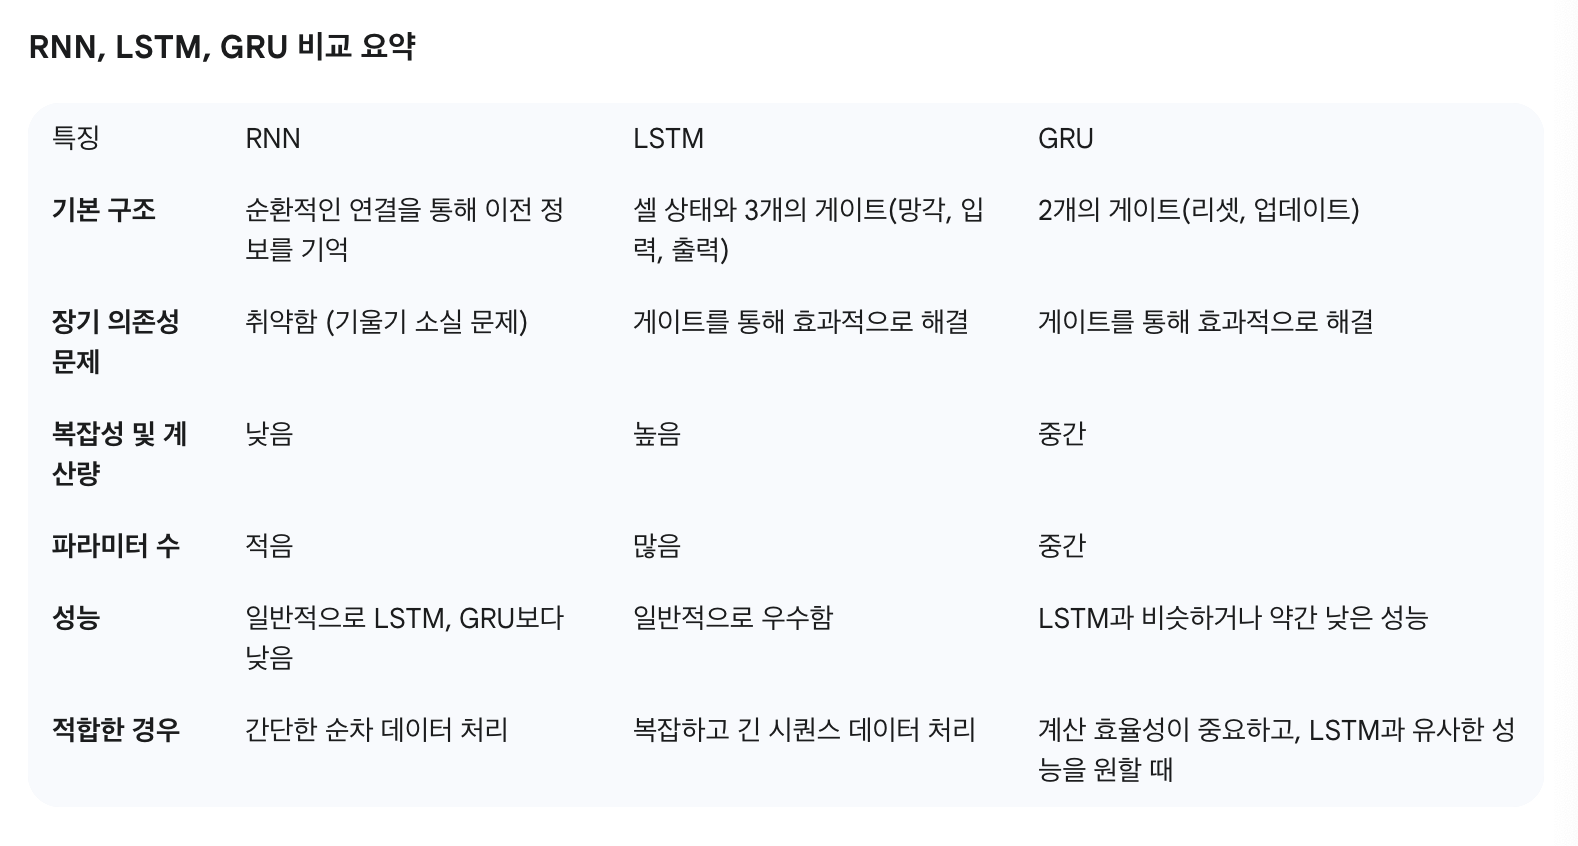

In [6]:
VOCAB_SIZE = 300    # 사용할 단어 수
SEQ_LEN = 150       # 시퀀스 하나의 최대 길이

### 데이터 준비

In [2]:
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=VOCAB_SIZE)

In [ ]:
# Torch Tensor 변환
import torch

train_input = [torch.tensor(seq, dtype=torch.long) for seq in train_input][:10000]
test_input = [torch.tensor(seq, dtype=torch.long) for seq in test_input][:5000]

train_target = torch.tensor(train_target, dtype=torch.long)[:10000]
test_target = torch.tensor(test_target, dtype=torch.long)[:5000]

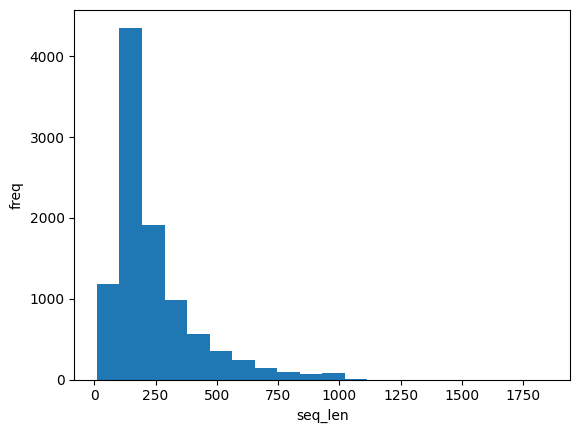

In [ ]:
# 시퀀스 길이 빈도 확인 (시각화)
import matplotlib.pyplot as plt

train_len = [len(seq) for seq in train_input]

plt.hist(train_len, bins=20)
plt.xlabel('seq_len')
plt.ylabel('freq')
plt.show()

In [ ]:
# 패딩 처리
import torch.nn.functional as F

def pad_sequences(sequences, maxlen, padding_value=0):
    padded_sequences = [F.pad(seq[:maxlen], (0, max(0, maxlen-len(seq))), value=padding_value) for seq in sequences]
    return torch.stack(padded_sequences)

train_seq = pad_sequences(train_input, maxlen=SEQ_LEN)
test_seq = pad_sequences(test_input, maxlen=SEQ_LEN)

In [ ]:
# 원핫인코딩 처리
train_onehot = F.one_hot(train_seq, num_classes=VOCAB_SIZE).float()
test_onehot = F.one_hot(test_seq, num_classes=VOCAB_SIZE).float()

train_onehot.shape, test_onehot.shape

(torch.Size([10000, 150, 300]), torch.Size([5000, 150, 300]))

### 모델 준비 및 학습

In [ ]:
import torch.nn as nn

# 간단한 RNN 모델 정의
class SentimentRNN(nn.Module):
    def __init__(self, seq_len, vocab_size, hidden_dim, output_dim):
        super(SentimentRNN, self).__init__()
        self.rnn = nn.RNN(input_size=vocab_size, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, hidden = self.rnn(x)
        out = self.fc(hidden.squeeze(0))
        return self.sigmoid(out)

In [10]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1

model = SentimentRNN(
    seq_len=SEQ_LEN,
    vocab_size=VOCAB_SIZE,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM
)

print(model)

SentimentRNN(
  (rnn): RNN(300, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# 학습을 위한 설정

import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split

# 배치 사이즈, 학습/검증셋 크기 설정
BATCH_SIZE = 65
train_size = int(len(train_onehot) * 0.8)
val_size = len(train_onehot) - train_size

# label 데이터 실수 처리
train_target = train_target.float()
test_target = test_target.float()

# 데이터 학습/검증셋 분할
train_dataset, val_dataset = random_split(TensorDataset(train_onehot, train_target), [train_size, val_size])
# 미니배치로 사용할 수 있도록 DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# epoch(학습 횟수), 손실 함수, 최적화 함수 정의
epochs = 100
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# 시각화를 위한 손실값/정확도 저장용 배열 생성 
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# 조기종료 관련 변수 초기화
early_stopping_patience = 7
best_val_loss = float('inf')
early_stop_counter = 0

In [ ]:
# 학습 진행

for epoch in range(epochs):

    # 학습 모드
    model.train()
    total_loss, correct, total = 0, 0, 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()               # 가중치 초기화
        outputs = model(inputs).squeeze()   # 순전파

        loss = criterion(outputs, targets)  # 손실 계산

        loss.backward()                     # 역전파
        optimizer.step()                    # 가중치 갱신
        total_loss += loss.item()

        pred = (outputs > 0.5).float()
        correct += (pred == targets).sum().item()
        total += targets.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # 검증 모드
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs).squeeze()
            loss = criterion(val_outputs, val_targets)
            val_loss += loss.item()

            val_pred = (val_outputs > 0.5).float()
            val_correct += (val_pred == val_targets).sum().item()
            val_total += val_targets.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # 조기 종료
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stopping_patience:
            print("Early Stopping 할게~~~~~!")
            break

Epoch 1/100 | Train Loss: 0.6952, Train Acc: 0.5022, Val Loss: 0.6958, Val Acc: 0.4805
Epoch 2/100 | Train Loss: 0.6915, Train Acc: 0.5199, Val Loss: 0.6956, Val Acc: 0.4975
Epoch 3/100 | Train Loss: 0.6856, Train Acc: 0.5419, Val Loss: 0.6955, Val Acc: 0.5035
Epoch 4/100 | Train Loss: 0.6753, Train Acc: 0.5653, Val Loss: 0.7041, Val Acc: 0.5065
Epoch 5/100 | Train Loss: 0.6629, Train Acc: 0.5815, Val Loss: 0.7143, Val Acc: 0.5045
Epoch 6/100 | Train Loss: 0.6526, Train Acc: 0.5856, Val Loss: 0.7208, Val Acc: 0.5090
Epoch 7/100 | Train Loss: 0.6424, Train Acc: 0.6084, Val Loss: 0.7302, Val Acc: 0.5070
Epoch 8/100 | Train Loss: 0.6341, Train Acc: 0.6116, Val Loss: 0.7301, Val Acc: 0.5115
Epoch 9/100 | Train Loss: 0.6266, Train Acc: 0.6184, Val Loss: 0.7357, Val Acc: 0.5235
Epoch 10/100 | Train Loss: 0.6218, Train Acc: 0.6258, Val Loss: 0.7441, Val Acc: 0.5175
Early Stopping 할게~~~~~!


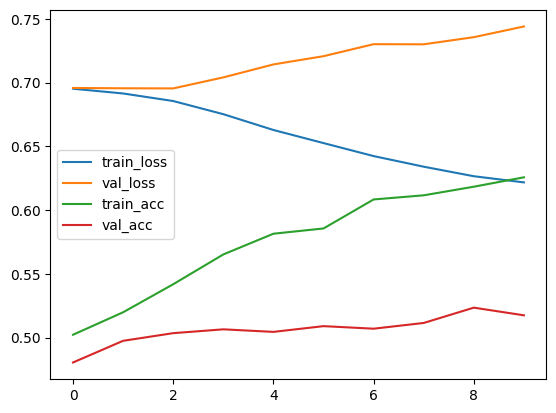

In [ ]:
# 학습 과정 시각화
train_history_df = pd.DataFrame({
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs
})

train_history_df.plot()
plt.show()

In [ ]:
# 평가 함수 정의
def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for val_inputs, val_targets in test_loader:
            val_outputs = model(val_inputs).squeeze()
            loss = criterion(val_outputs, val_targets)
            val_loss += loss.item()

            val_pred = (val_outputs > 0.5).float()
            val_correct += (val_pred == val_targets).sum().item()
            val_total += val_targets.size(0)

    val_loss = val_loss / len(test_loader)
    val_acc = val_correct / val_total
    return val_loss, val_acc

In [15]:
test_dataset = TensorDataset(test_onehot, test_target)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

loss, accuracy = evaluate_model(model, test_loader, criterion)
loss, accuracy

(0.7519504745285233, 0.522)